In [2]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from IPython.display import HTML, display
import json
from collections import Counter
import pandas as pd
import numpy as np
from utilities import *

register_matplotlib_converters()
pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

ModuleNotFoundError: No module named 'ebmdatalab'

In [4]:
df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_rate.csv', parse_dates=['date'])

def calculate_rate(df, value_col, population_col, rate_per=1000):
    num_per_thousand = df[value_col]/(df[population_col]/rate_per)
    return num_per_thousand

df['rate'] = calculate_rate(df, 'doac', 'population')

codelist = pd.read_csv('../codelists/opensafely-mechanical-or-artificial-valves.csv')


## DOAC Use in Patients with Mechanical Heart Valves


### Total Number

In [5]:
population = df.groupby(by='date')[['population']].sum().reset_index()
events = df.groupby(by='date')[['doac']].mean().reset_index()
total_df = df.groupby(by='date')[['rate']].mean().reset_index()

total_df = total_df.merge(events, on='date').merge(population, on='date')

def redact_small_numbers(df, n, numerator, denominator, rate_column):
    """
    Takes counts df as input and suppresses low numbers.  Sequentially redacts
    low numbers from numerator and denominator until count of redcted values >=n.
    Rates corresponding to redacted values are also redacted.
    
    df: input df
    n: threshold for low number suppression
    numerator: numerator column to be redacted
    denominator: denominator column to be redacted
    """
    
    def suppress_column(column):    
        suppressed_count = column[column<=n].sum()
        
        #if 0 dont need to suppress anything
        if suppressed_count == 0:
            pass
        
        else:
            df[column.name][df[column.name]<=n] = np.nan
            

            while suppressed_count <=n:
                suppressed_count += column.min()
                column.iloc[column.idxmin()] = np.nan   
        return column
    
    
    for column in [numerator, denominator]:
        df[column] = suppress_column(df[column])
    
    df[rate_column][(df[numerator].isna())| (df[denominator].isna())] = np.nan
    
    return df    

total_df = redact_small_numbers(total_df, 5, 'doac', 'population', 'rate')


def plot_measures(df, title,column_to_plot, filename,category=False, y_label='Rate per 1000', interactive=True):

    if interactive:

        fig = go.Figure()

        if category:
            for unique_category in df[category].unique():

                df_subset = df[df[category] == unique_category]
                fig.add_trace(go.Scatter(
                    x=df_subset['date'], y=df_subset[column_to_plot], name=unique_category))

        else:
            fig.add_trace(go.Scatter(
                x=df['date'], y=df[column_to_plot]))

        # Set title
        fig.update_layout(
            title_text=title,
            hovermode='x',
            title_x=0.5,
            yaxis=dict(
            range=[0, 7000]
        )


        )

        fig.update_yaxes(title=y_label)
        fig.update_xaxes(title="Date")

        # Add range slider
        fig.update_layout(
            xaxis=go.layout.XAxis(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                            label="1m",
                            step="month",
                            stepmode="backward"),
                        dict(count=6,
                            label="6m",
                            step="month",
                            stepmode="backward"),

                        dict(count=1,
                            label="1y",
                            step="year",
                            stepmode="backward"),
                        dict(step="all")
                    ])
                ),
                rangeslider=dict(
                    visible=True
                ),
                type="date"
            )
        )

        fig.show()

    else:

        if category:
            for unique_category in df[category].unique():

                df_subset = df[df[category] == unique_category]

                plt.plot(df_subset['date'], df_subset[column_to_plot], marker='o')
        else:
            plt.plot(df['date'], df[column_to_plot])

        plt.ylabel(y_label)
        plt.xlabel('Date')
        plt.ylim(bottom=0)
        plt.xticks(rotation='vertical')
        plt.title(title)

        if category:
            plt.legend(df[category].unique(), bbox_to_anchor=(
                1.04, 1), loc="upper left")

        else:
            pass
        plt.tight_layout()
        plt.savefig(f'../output/measure_{filename}.jpeg')
        plt.show()
        
        plt.clf()

<ipython-input-5-f1dc5b519c37>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[rate_column][(df[numerator].isna())| (df[denominator].isna())] = np.nan


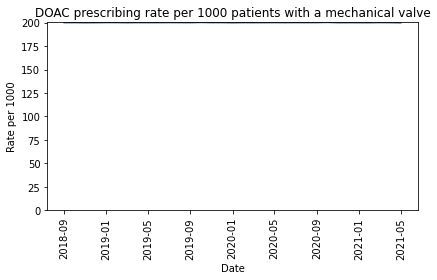

<Figure size 432x288 with 0 Axes>

In [6]:
plot_measures(total_df, title='DOAC prescribing rate per 1000 patients with a mechanical valve', column_to_plot='rate', category=False, y_label='Rate per 1000', interactive=False, filename="total")


### STP Breakdown

In [ ]:
df_stp = pd.read_csv('../output/measure_stp_rate.csv', parse_dates=['date'])
df_stp['rate'] = calculate_rate(df_stp, 'doac', 'population')

deciles_chart(df_stp, period_column='date', column='rate', title='Decile chart',ylabel='rate per 1000', interactive=False)
plt.tight_layout()
plt.savefig('../output/measure_stp.jpeg')

### Mechanical Valve Type

Mechanical valve type of those with mechanical valve currently prescribed a DOAC

In [7]:
def group_low_values(df, value_col, population_col, term_col):
    
    df = df[df[value_col] > 0]
    suppressed_count = df[df[value_col]<=5][value_col].sum()
    population_suppressed_count = df[df[value_col]<=5][population_col].sum()
    
    if suppressed_count == 0:
        pass

    else:
        df[value_col][df[value_col] <=5]  = np.nan

        while suppressed_count <=10:

            suppressed_count += df[value_col].min()
            df[value_col].iloc[df[value_col].idxmin()] = np.nan 
            
            population_suppressed_count += df[population_col].iloc[df[value_col].idxmin()]
            df[population_col].iloc[df[value_col].idxmin()] = np.nan


    dropped_rows = df[df[value_col].isnull()][term_col].values

    df = df[df[value_col].notnull()]
    
    
    
    return df, dropped_rows, suppressed_count, population_suppressed_count

In [9]:
valve_type_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_valve_code_rate.csv', parse_dates=['date'])
valve_type_df_now = valve_type_df[valve_type_df['date']== '2021-05-01']
valve_type_df_now = valve_type_df_now.drop('value', axis=1)



valve_type_df_now = valve_type_df_now.merge(codelist, left_on='mechanical_valve_code', right_on='code', how='left')
valve_type_df_now = valve_type_df_now.drop(columns='code')
valve_type_df_now


valve_type_df_now, dropped_rows, suppressed_count, population_suppressed_count = group_low_values(valve_type_df_now, 'doac_3_months', 'population', 'term')


In [10]:
valve_type_df_now

,mechanical_valve_code,doac_3_months,population,date,term
0,NaN,2379.0,12000,2021-05-01,NaN
1,174920003.0,621.0,3000,2021-05-01,Prosthetic mitral valve replacement (& [Bjork ...


In [12]:
print(f'suppressed count: {suppressed_count}')
print(f'population suppressed: {population_suppressed_count}')
print(dropped_rows)

suppressed count: 0.0
population suppressed: 0
[]


### Demographic breakdown

In [ ]:
# from collections import Counter

# recent_df = pd.read_csv('../output/input_demographics.csv')
# demographic_df = 
# demographic_df_doac = demographic_df[(demographic_df['mechanical_valve']==1)&(demographic_df['doac']==1)]



# demographics = ['sex', 'age_band', 'atrial_fib', 'imd', 'eth2001']
# demographic_counts = {}

# for dem in demographics:
    
#     if dem == "imd":
#         demographic_df_doac["imd"] = pd.qcut(demographic_df_doac["imd"], q=5,duplicates="drop")  
#     column = demographic_df_doac[dem]
#     count_dict = Counter(column.dropna())
    
#     demographic_counts[dem] = count_dict


#### Sex

In [ ]:
# sex_dict = demographic_counts['sex']
# sex_df = pd.DataFrame.from_dict(sex_dict, orient='index').rename(columns={'index': 'row', 0: 'count'})

# total = sex_df['count'].sum()

# # other_count = 0
# # def get_other_count(row, other_count):
# #     count = row['count']
# #     if count<=5:
# #         other_count+=count

# # sex_df.apply(lambda row: get_other_count(row, other_count), axis=1)
# # sex_df = sex_df[sex_df['count']>5]      

# # if other_count >5:
# #     sex_df = sex_df.append(pd.DataFrame([other_count], columns=['count']))


# def calculate_percent(row, total):
#     row['%'] = (row['count']/total)*100
#     return row
# sex_df = sex_df.apply(lambda row: calculate_percent(row, total), axis=1)


# sex_df

#### Ethnicity

In [ ]:
# ethnicity_dict = demographic_counts['eth2001']
# ethnicity_df = pd.DataFrame.from_dict(ethnicity_dict, orient='index').rename(columns={'index': 'row', 0: 'count'})

# total = ethnicity_df['count'].sum()

# # other_count = 0
# # def get_other_count(row, other_count):
# #     count = row['count']
# #     if count<=5:
# #         other_count+=count

# # ethnicity_df.apply(lambda row: get_other_count(row, other_count), axis=1)
# # ethnicity_df = ethnicity_df[ethnicity_df['count']>5]      

# # if other_count >5:
# #     ethnicity_df = ethnicity_df.append(pd.DataFrame([other_count], columns=['count']))


# def calculate_percent(row, total):
#     row['%'] = (row['count']/total)*100
#     return row
# ethnicity_df = ethnicity_df.apply(lambda row: calculate_percent(row, total), axis=1)


# ethnicity_df

#### IMD

In [ ]:
# imd_dict = demographic_counts['imd']
# imd_df = pd.DataFrame.from_dict(imd_dict, orient='index').rename(columns={'index': 'row', 0: 'count'})

# total = imd_df['count'].sum()

# # other_count = 0
# # def get_other_count(row, other_count):
# #     count = row['count']
# #     if count<=5:
# #         other_count+=count

# # imd_df.apply(lambda row: get_other_count(row, other_count), axis=1)
# # imd_df = imd_df[imd_df['count']>5]      

# # if other_count >5:
# #     imd_df = imd_df.append(pd.DataFrame([other_count], columns=['count']))


# def calculate_percent(row, total):
#     row['%'] = (row['count']/total)*100
#     return row
# imd_df = imd_df.apply(lambda row: calculate_percent(row, total), axis=1)


# imd_df

#### AF

In [ ]:
# af_dict = demographic_counts['atrial_fib']
# af_df = pd.DataFrame.from_dict(af_dict, orient='index').rename(columns={'index': 'row', 0: 'count'})

# total = af_df['count'].sum()

# # other_count = 0
# # def get_other_count(row, other_count):
# #     count = row['count']
# #     if count<=5:
# #         other_count+=count

# # af_df.apply(lambda row: get_other_count(row, other_count), axis=1)
# # af_df = af_df[af_df['count']>5]      

# # if other_count >5:
# #     af_df = af_df.append(pd.DataFrame([other_count], columns=['count']))


# def calculate_percent(row, total):
#     row['%'] = (row['count']/total)*100
#     return row
# af_df = af_df.apply(lambda row: calculate_percent(row, total), axis=1)


# af_df

#### Age Band

In [ ]:
# age_dict = demographic_counts['age_band']
# age_df = pd.DataFrame.from_dict(age_dict, orient='index').rename(columns={'index': 'row', 0: 'count'})

# total = age_df['count'].sum()

# # other_count = 0
# # def get_other_count(row, other_count):
# #     count = row['count']
# #     if count<=5:
# #         other_count+=count

# # age_df.apply(lambda row: get_other_count(row, other_count), axis=1)
# # age_df = age_df[age_df['count']>5]      

# # if other_count >5:
# #     age_df = age_df.append(pd.DataFrame([other_count], columns=['count']))


# def calculate_percent(row, total):
#     row['%'] = (row['count']/total)*100
#     return row
# age_df = age_df.apply(lambda row: calculate_percent(row, total), axis=1)


# age_df